# Double Deep Q Newtork (DDQN) for Super Mario Bros.


## Imports


In [1]:
import os
import warnings

import gym_super_mario_bros
import numpy as np
import matplotlib.pyplot as plt
import torch
from gym.wrappers import (
    FrameStack,
    GrayScaleObservation,
    Monitor,
    ResizeObservation,
    TransformObservation,
)
from nes_py.wrappers import JoypadSpace
from tqdm import tqdm

from setup import create_directories
from src.DDQNAgent import MarioAgentEpsilonGreedy
from src.utils import plot_results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device(
#     "mps"
#     if torch.backends.mps.is_available() and torch.backends.mps.is_built()
#     else "cpu"
# )
np.random.seed(42)
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
warnings.simplefilter("ignore")
print(device)

cuda


## Setup


### Set all Paths


In [2]:
train_version = None
agent = "ddqn"
create_directories(agent)

model_folder = (
    os.path.join("models", agent)
    if train_version == None
    else os.path.join("models", f"{agent}_v{train_version}")
)
checkpoint_folder = os.path.join(model_folder, "checkpoints")

videos_folder = (
    os.path.join("references", agent, "videos")
    if train_version == None
    else os.path.join("references", f"{agent}_v{train_version}", "videos")
)
plot_folder = (
    os.path.join("references", agent, "images")
    if train_version == None
    else os.path.join("references", f"{agent}_v{train_version}", "images")
)
evaluation_folder = (
    os.path.join("references", agent, "evaluation")
    if train_version == None
    else os.path.join("references", f"{agent}_v{train_version}", "evaluation")
)


# set path for checkpoint to load from
starting_point = None  # os.path.join(checkpoint_folder, "model_ep850.pth")

### Set Hyperparameters


In [3]:
action_space = [
    ["NOOP"],
    ["A"],
    ["B"],
    ["right"],
    ["left"],
    ["right", "A"],
    ["right", "B"],
    ["right", "A", "B"],
]
buffer_size = 25000
batch_size = 64
learning_rate = 0.00009
stacking_number = 10
online_update_every = 3
exp_before_target_sync = 5000
exp_before_training = batch_size + 5
epsilon_start = 1.0
epsilon_min = 0.01
epsilon_decay = 0.001
gamma = 0.99
num_episodes = 1000
plot_every = 100
save_every = 100

## Train Agent


### Initialize Environment and other variables


In [4]:
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, action_space)
env = Monitor(env, videos_folder, video_callable=lambda episode_id: episode_id % 100 == 0, force=True)
env = GrayScaleObservation(env, keep_dim=False)
env = ResizeObservation(env, shape=84)
env = TransformObservation(env, lambda obs: np.squeeze(obs, axis=-1))
env = TransformObservation(env, f=lambda x: x / 255.0)
env = FrameStack(env, num_stack=stacking_number)

state = env.reset()
state_shape = state.shape


mario = MarioAgentEpsilonGreedy(
    num_actions=len(action_space),
    state_shape=state_shape,
    checkpoint_folder=checkpoint_folder,
    model_folder=model_folder,
    wantcuda=True,
    starting_point=starting_point,
    learning_rate=learning_rate,
    epsilon_start=epsilon_start,
    epsilon_min=epsilon_min,
    epsilon_decay=epsilon_decay,
    batch_size=batch_size,
    gamma=gamma,
    buffer_size=buffer_size,
    exp_before_training=exp_before_training,
    online_update_every=online_update_every,
    exp_before_target_sync=exp_before_target_sync,
    save_every=save_every,
)

reward_list = []
steps_list = []
q_list = []
loss_list = []
epsilon_list = []

### Train Agent


Training: 100%|██████████| 1000/1000 [31:26:41<00:00, 113.20s/it]  


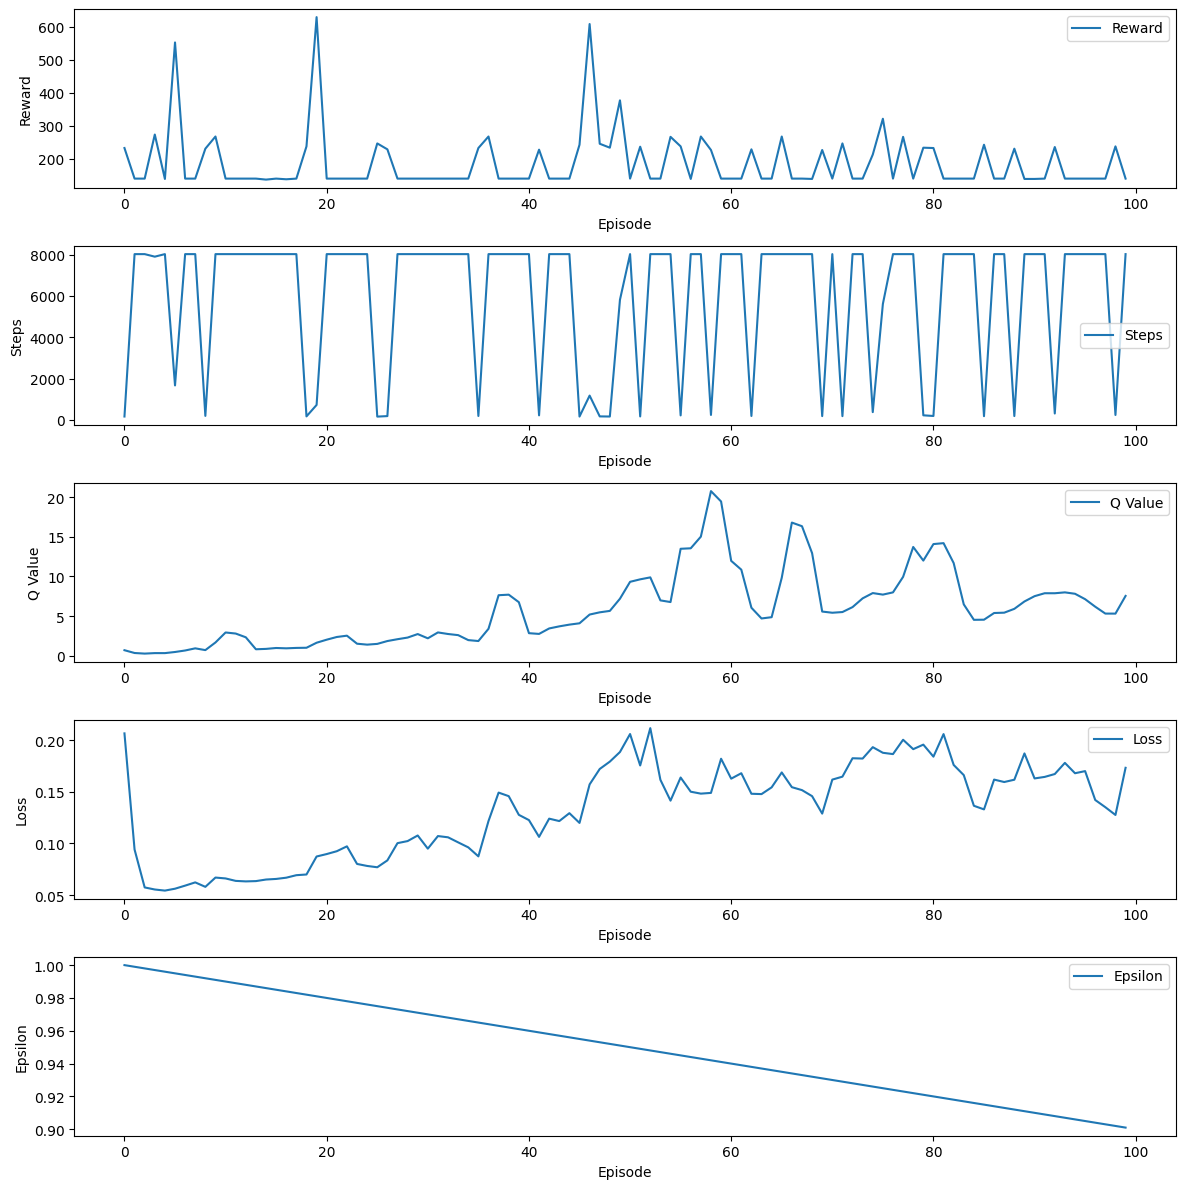

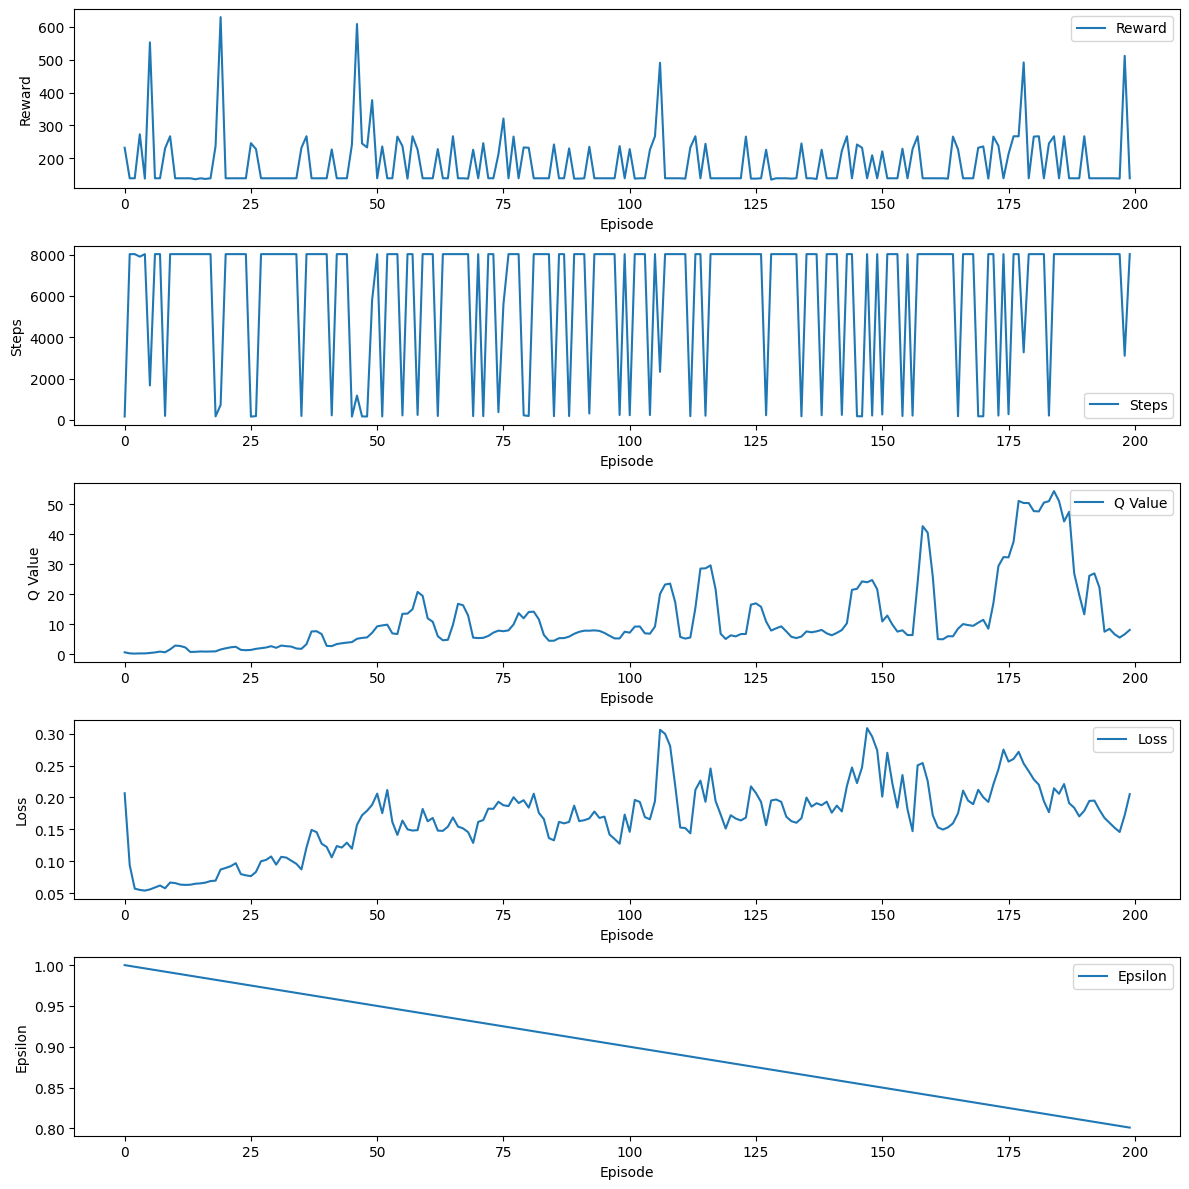

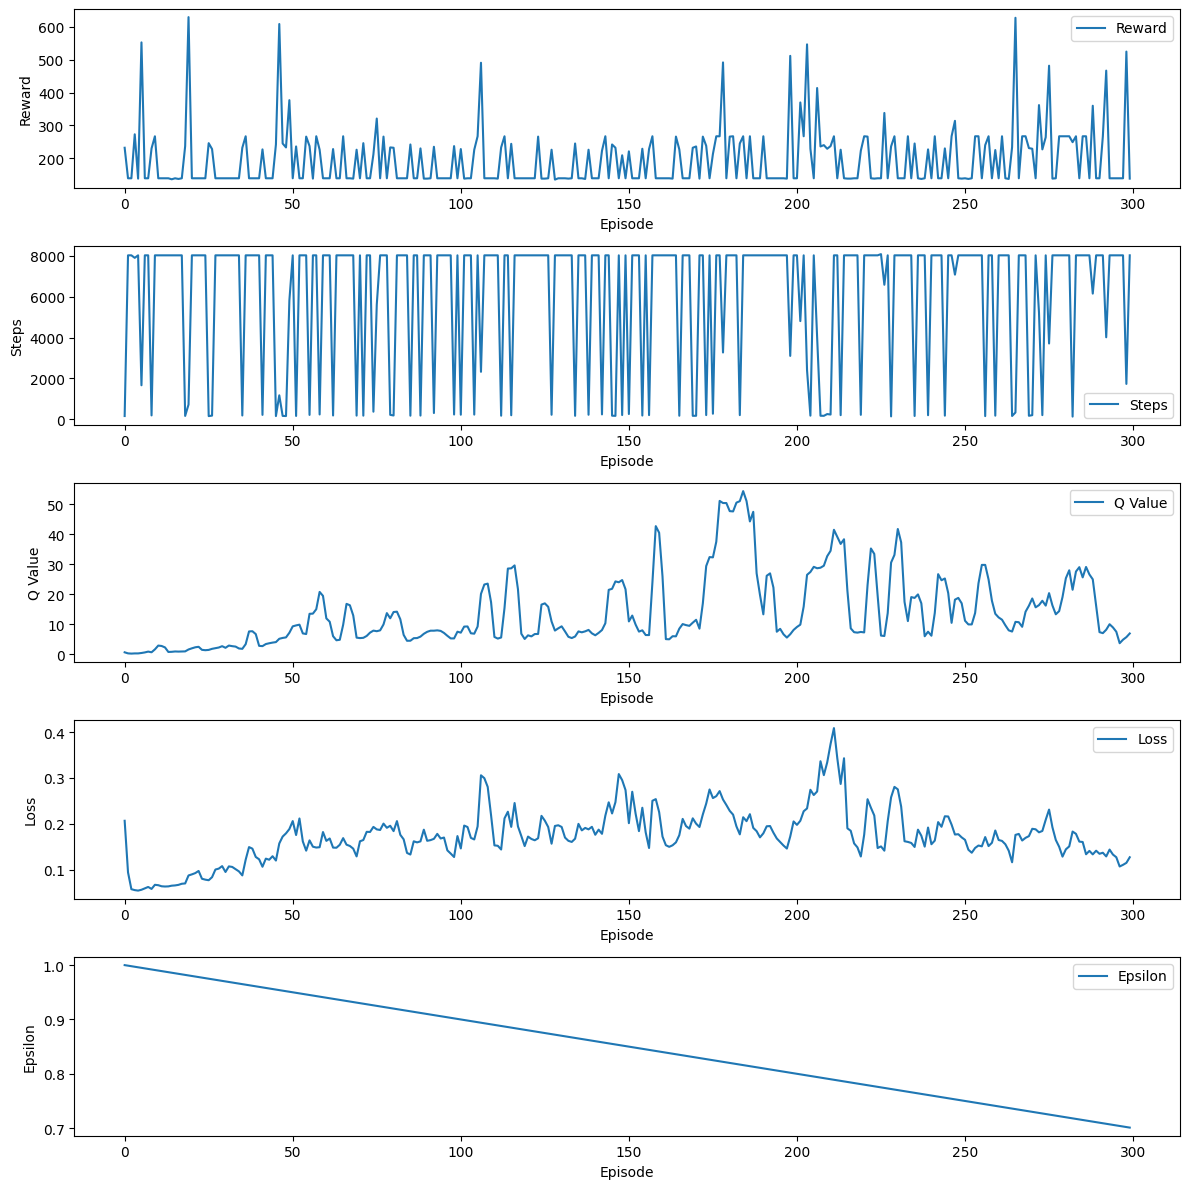

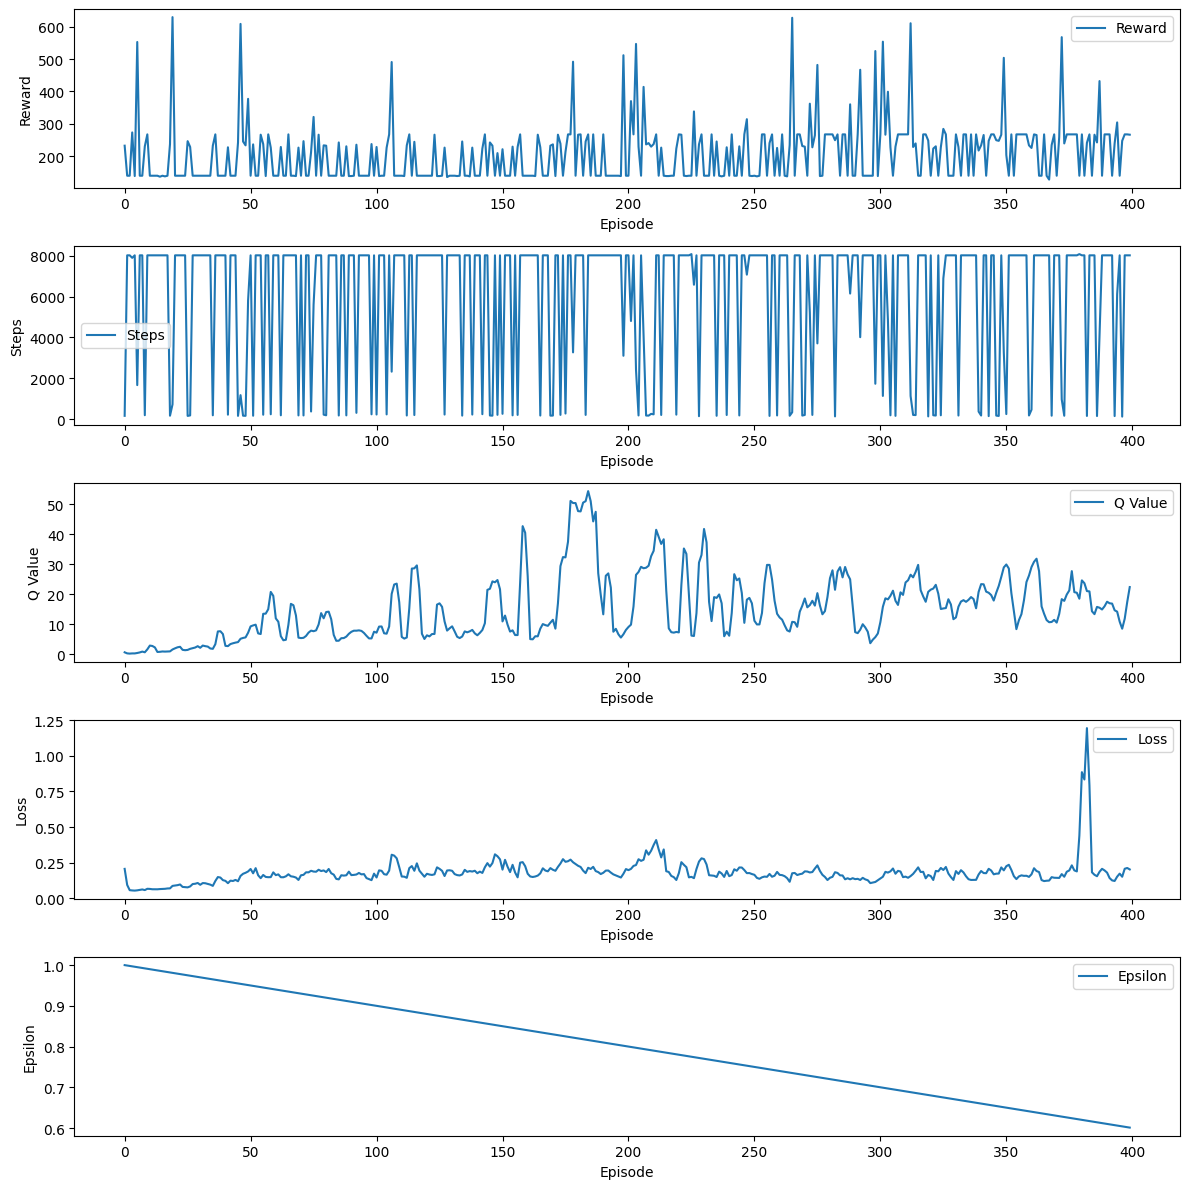

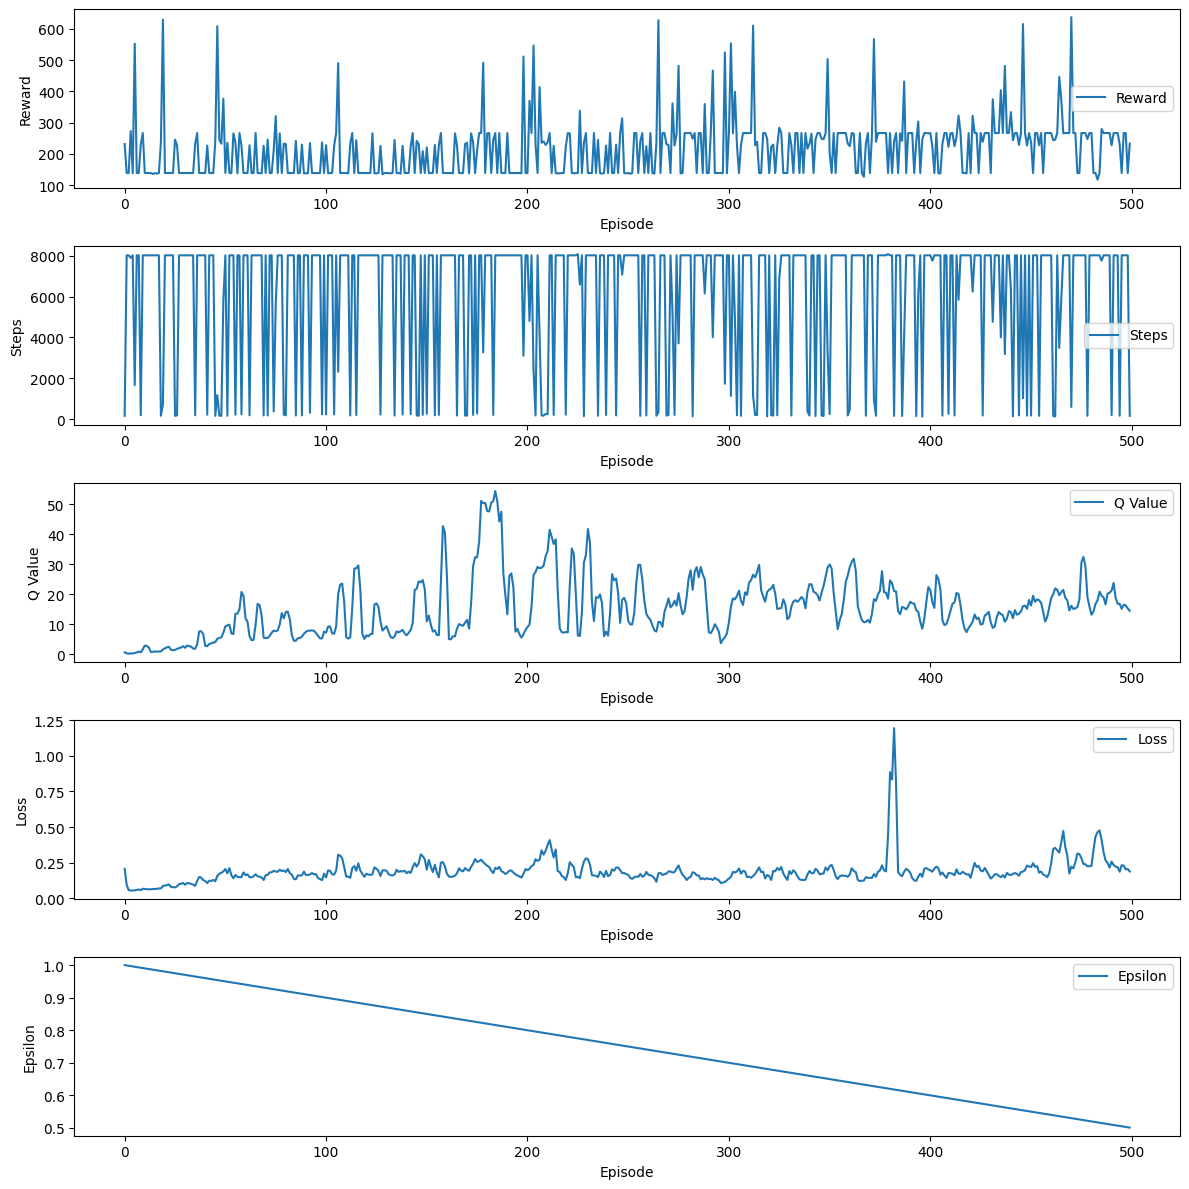

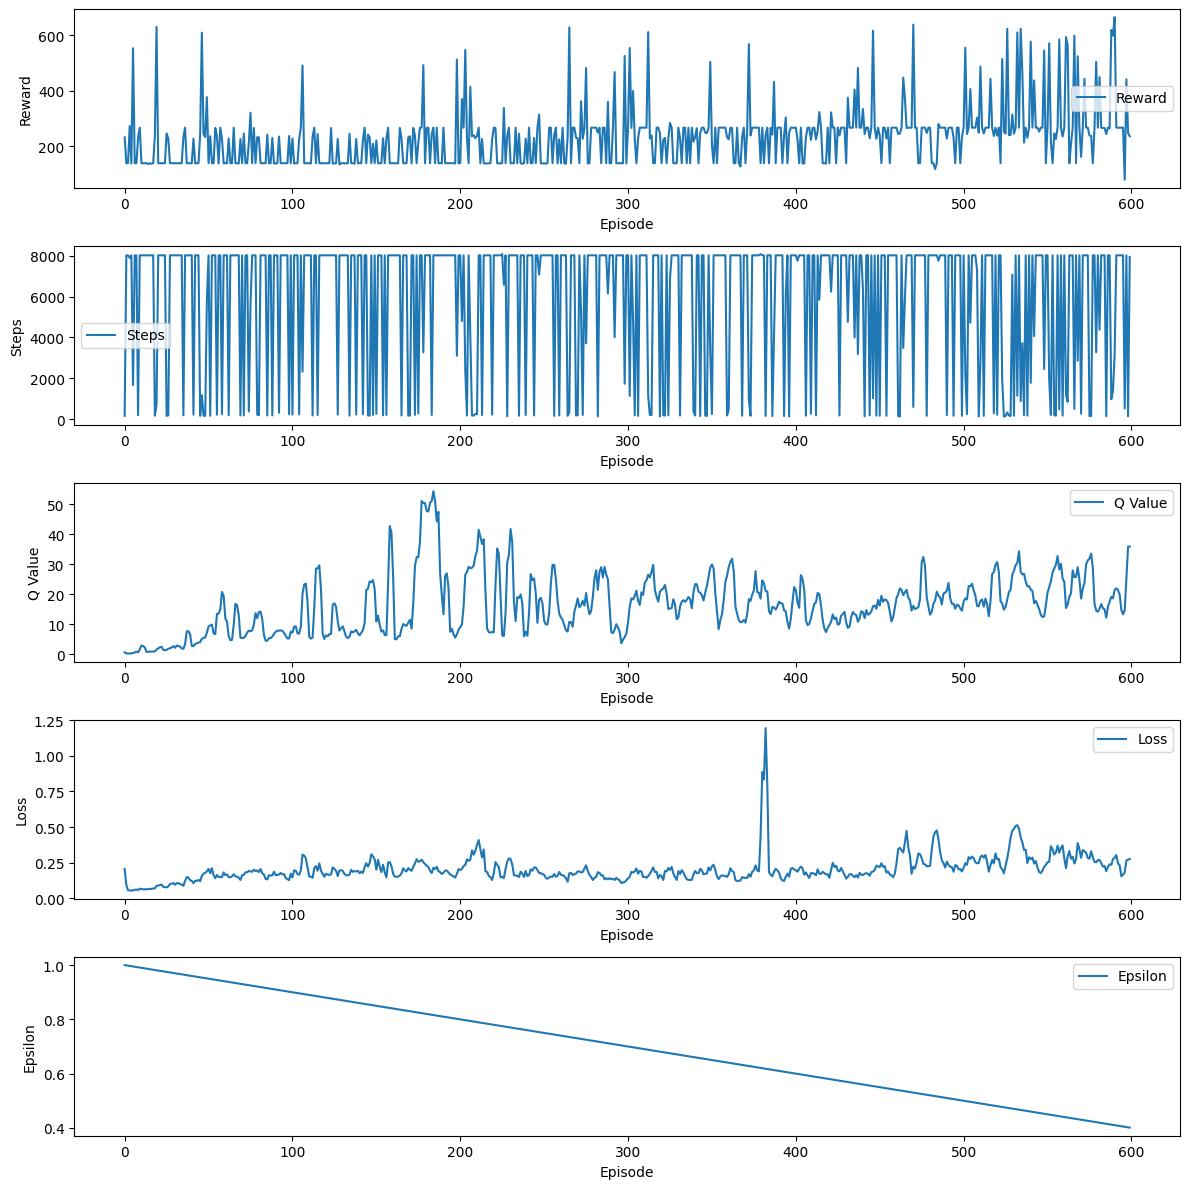

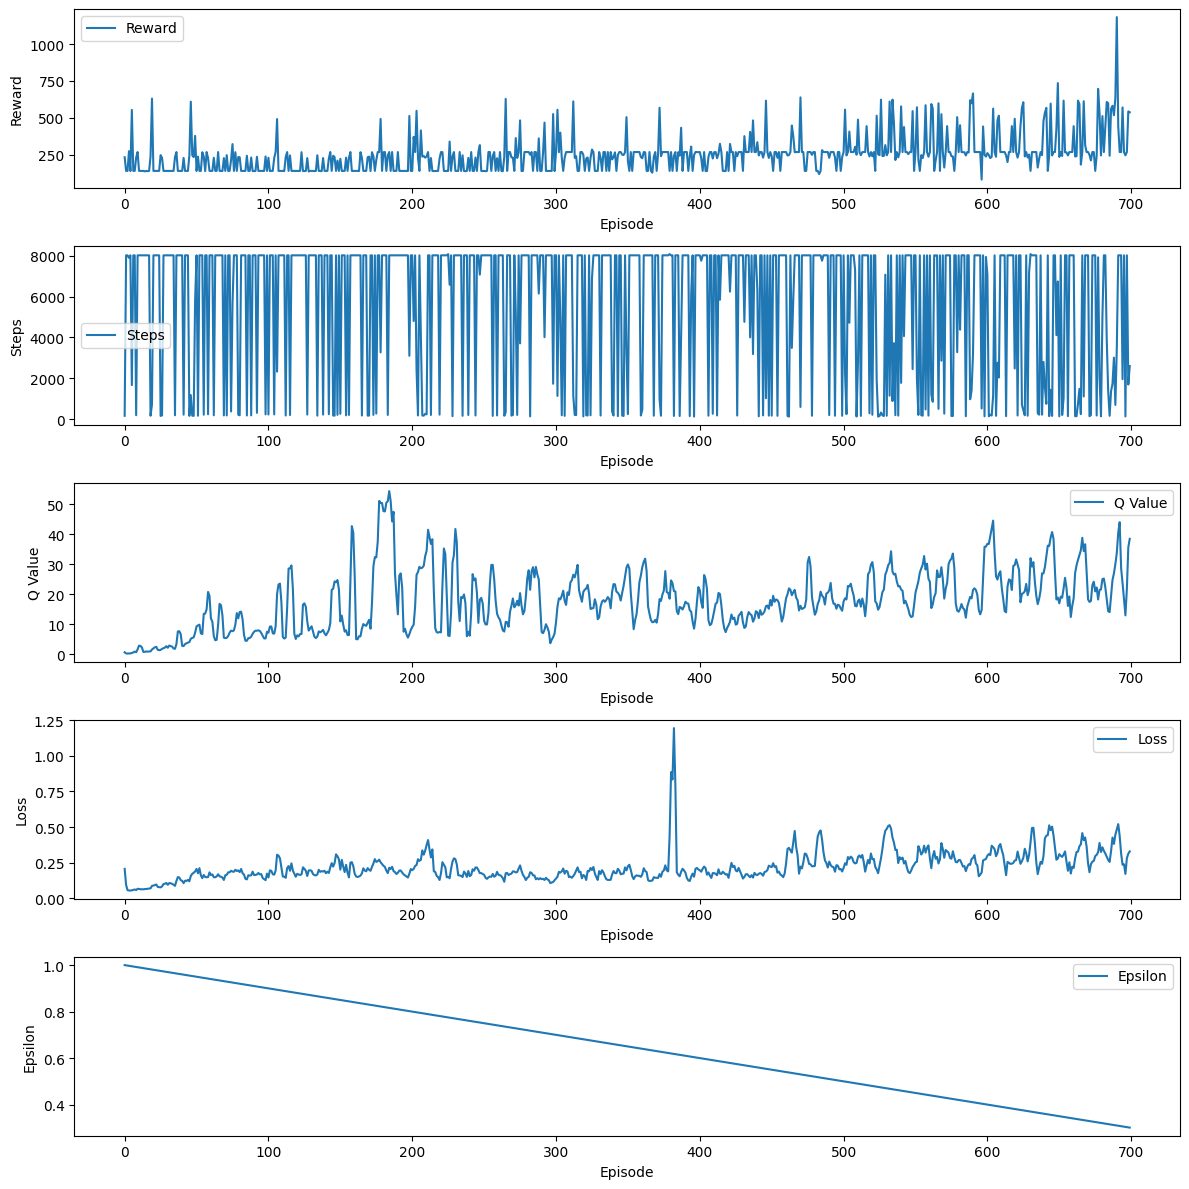

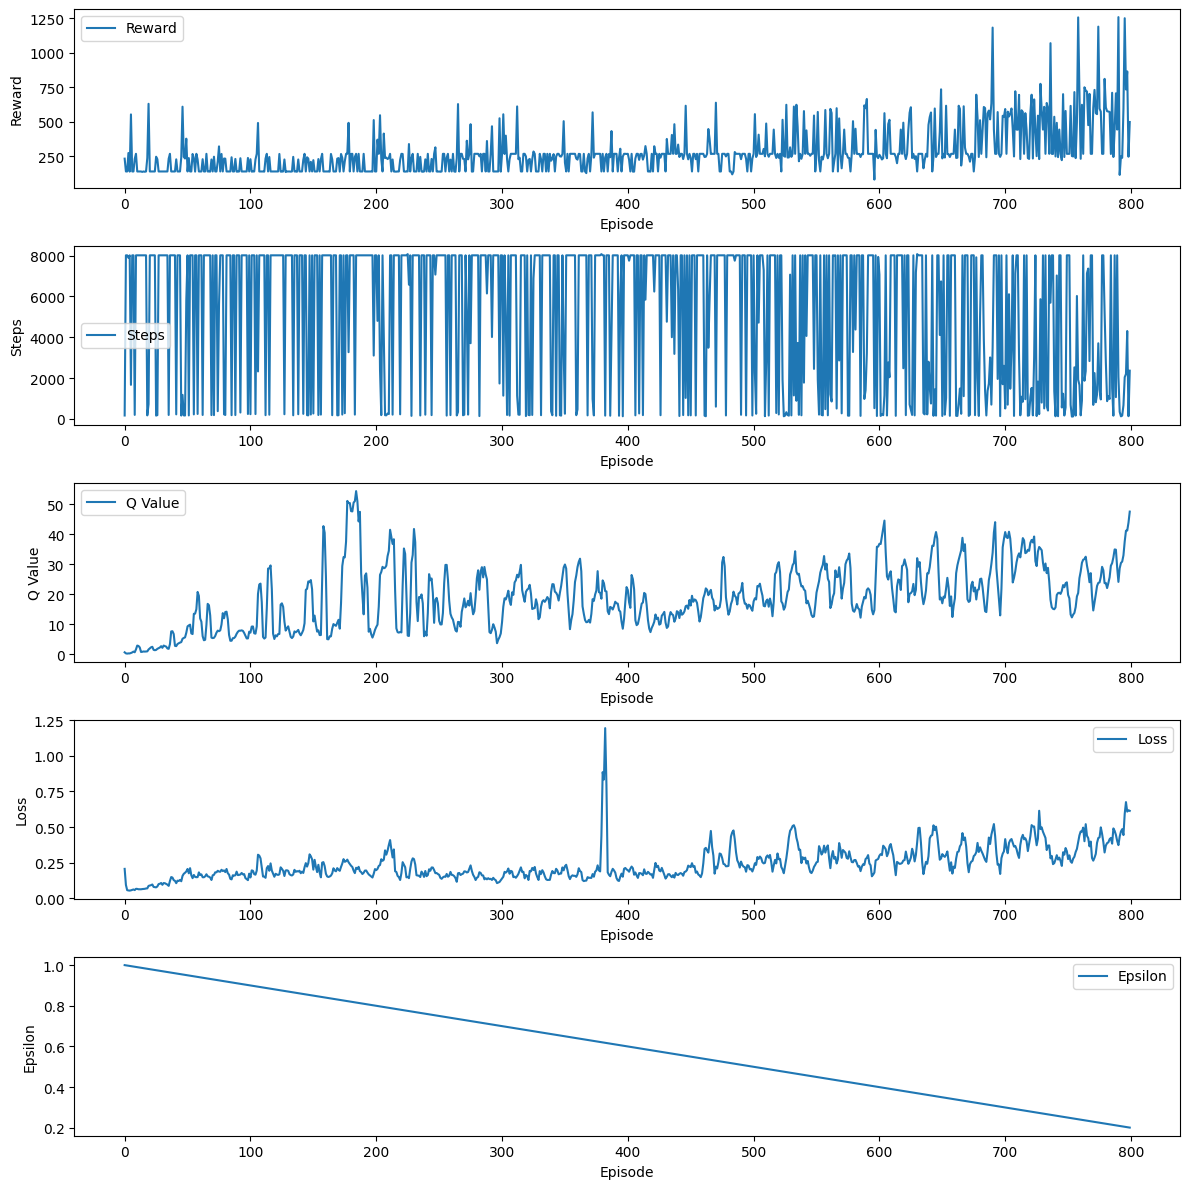

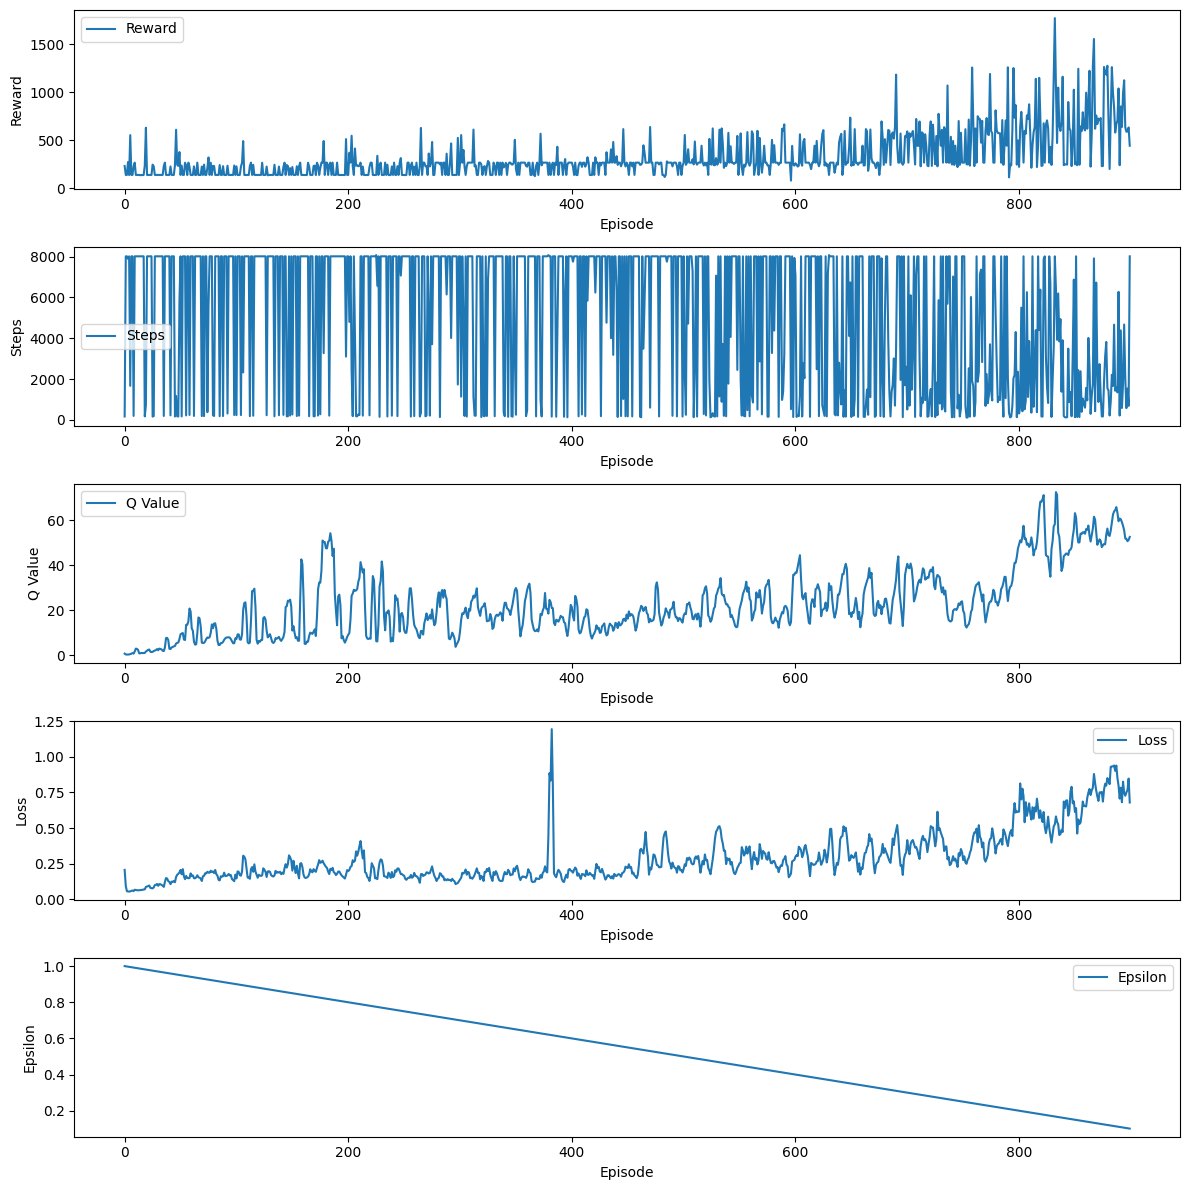

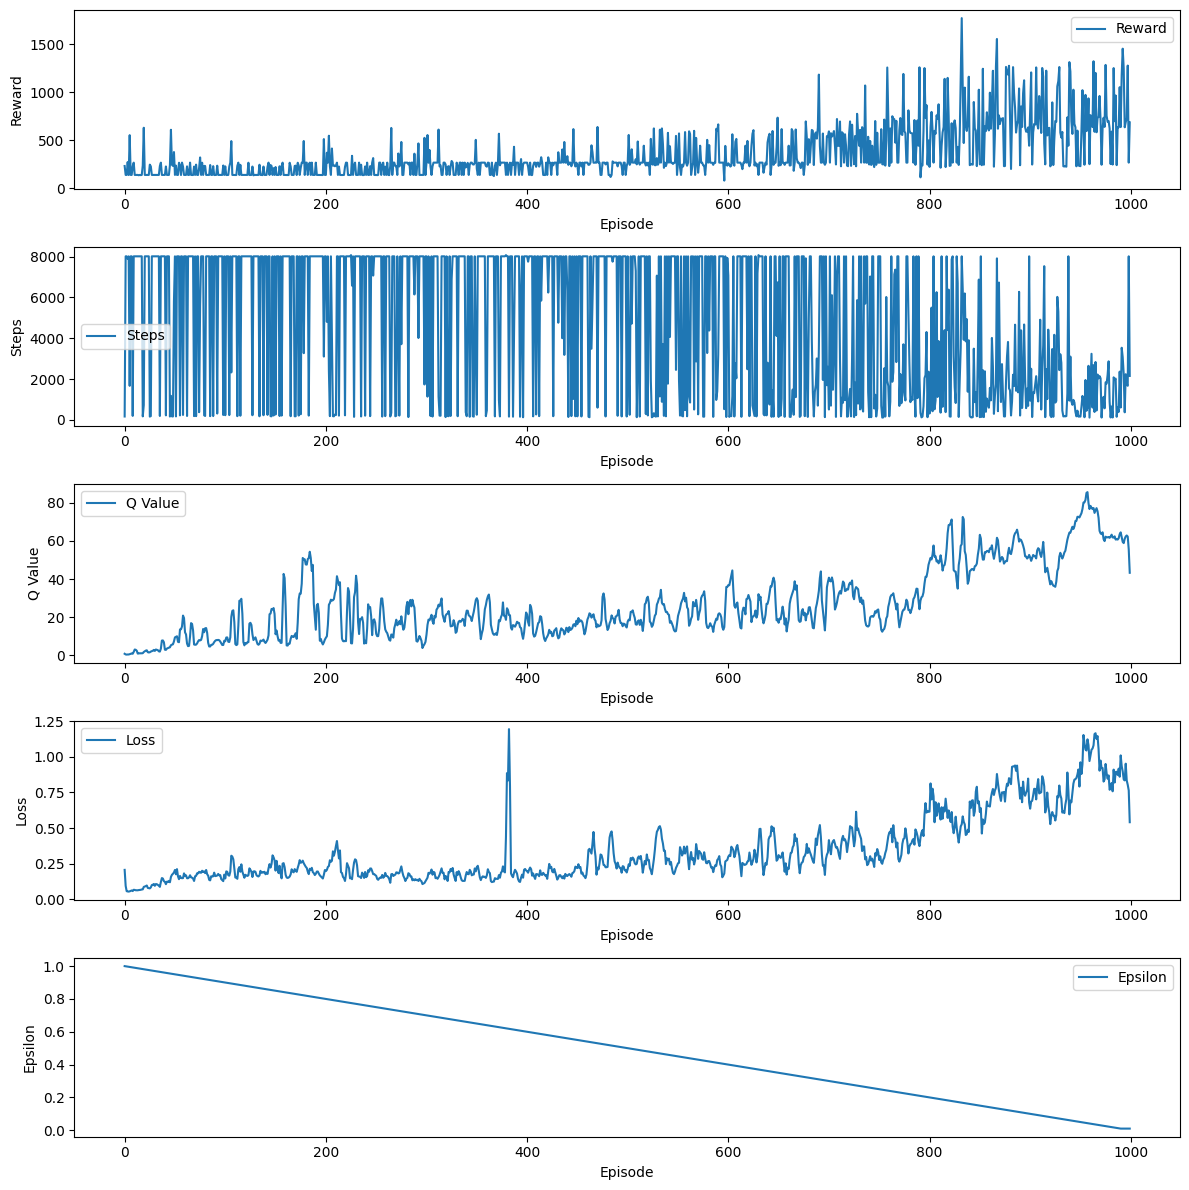

In [5]:
for episode in tqdm(range(1, num_episodes + 1), total=num_episodes, desc="Training"):
    state = env.reset()
    total_reward = 0
    steps = 0
    mean_episode_q = []
    mean_episode_loss = []
    # Initiate loop for the current episode to play the game until it ends
    while True:
        # To visualize the training, uncomment the following line
        # env.render()
        action = mario.selectAction(state)
        next_state, reward, resetnow, info = env.step(action)
        mario.saveExp(state, action, next_state, reward, resetnow)
        q, loss = mario.learn_get_TDest_loss()
        state = next_state
        total_reward = total_reward + reward
        steps = steps + 1
        mean_episode_q.append(q)
        mean_episode_loss.append(loss)
        if resetnow or info["flag_get"]:
            break

    # Save the results of the current episode
    reward_list.append(total_reward)
    steps_list.append(steps)
    q_list.append(np.mean(mean_episode_q))
    loss_list.append(np.mean(mean_episode_loss))
    epsilon_list.append(mario.epsilon)

    # Plot the results of all episodes at the defined intervals
    if episode % plot_every == 0:
        plot_results(
            reward_list=reward_list,
            steps_list=steps_list,
            q_list=q_list,
            loss_list=loss_list,
            epsilon_list=epsilon_list,
            save_fig=True,
            save_path=os.path.join(plot_folder, f"plot_{episode}.png"),
        )

    # Save the model at the defined intervals
    if episode % save_every == 0:
        torch.save(
            dict(
                model=mario.online.state_dict(),
                optimizer=mario.optimizer.state_dict(),
                epsilon=mario.epsilon,
            ),
            os.path.join(checkpoint_folder, f"model_ep{episode}.pth"),
        )

    # Decay the epsilon value at the end of each episode
    mario.decayEpsilon(strat="lin")

# Save the final model after all episodes are completed
torch.save(
    dict(
        model=mario.online.state_dict(),
        optimizer=mario.optimizer.state_dict(),
        epsilon=mario.epsilon,
    ),
    os.path.join(model_folder, f"final_model.pth"),
)

# Close the environment
env.close()

## Evaluate Agent


In [4]:
# load model
starting_point = os.path.join(model_folder, f"{agent}.pth")

### Initialize Environment and other variables


In [5]:
stacking_number = 10
num_episodes = 50

env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, action_space)
env = Monitor(env, videos_folder, video_callable=lambda episode_id: True, force=True)
env = GrayScaleObservation(env, keep_dim=False)
env = ResizeObservation(env, shape=84)
env = TransformObservation(env, lambda obs: np.squeeze(obs, axis=-1))
env = TransformObservation(env, f=lambda x: x / 255.0)
env = FrameStack(env, num_stack=stacking_number)


state = env.reset()
state_shape = state.shape

In [6]:
agent = mario = MarioAgentEpsilonGreedy(
    num_actions=len(action_space),
    state_shape=state_shape,
    wantcuda=True,
    checkpoint_folder=None,
    model_folder=None,
    starting_point=starting_point,
)
agent.epsilon = 0.0
agent.online.eval()
agent.target.eval()

reward_list = []
steps_list = []

Model loaded from models\ddqn\ddqn.pth with epsilon 0.01


### Evaluation Loop


  2%|▏         | 1/50 [00:02<01:53,  2.32s/it]

Episode 1 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




  4%|▍         | 2/50 [00:04<01:41,  2.12s/it]

Episode 2 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




  6%|▌         | 3/50 [00:06<01:37,  2.08s/it]

Episode 3 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




  8%|▊         | 4/50 [00:08<01:36,  2.09s/it]

Episode 4 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 10%|█         | 5/50 [00:10<01:35,  2.12s/it]

Episode 5 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 12%|█▏        | 6/50 [00:12<01:35,  2.17s/it]

Episode 6 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 14%|█▍        | 7/50 [00:15<01:33,  2.17s/it]

Episode 7 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 16%|█▌        | 8/50 [00:17<01:31,  2.17s/it]

Episode 8 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 18%|█▊        | 9/50 [00:19<01:28,  2.16s/it]

Episode 9 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 20%|██        | 10/50 [00:21<01:27,  2.18s/it]

Episode 10 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 22%|██▏       | 11/50 [00:23<01:24,  2.17s/it]

Episode 11 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 24%|██▍       | 12/50 [00:25<01:21,  2.16s/it]

Episode 12 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 26%|██▌       | 13/50 [00:27<01:19,  2.14s/it]

Episode 13 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 28%|██▊       | 14/50 [00:30<01:17,  2.15s/it]

Episode 14 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 30%|███       | 15/50 [00:32<01:15,  2.16s/it]

Episode 15 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 32%|███▏      | 16/50 [00:34<01:13,  2.17s/it]

Episode 16 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 34%|███▍      | 17/50 [00:36<01:11,  2.17s/it]

Episode 17 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 36%|███▌      | 18/50 [00:38<01:09,  2.17s/it]

Episode 18 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 38%|███▊      | 19/50 [00:41<01:07,  2.17s/it]

Episode 19 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 40%|████      | 20/50 [00:43<01:04,  2.16s/it]

Episode 20 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 42%|████▏     | 21/50 [00:45<01:02,  2.14s/it]

Episode 21 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 44%|████▍     | 22/50 [00:47<00:59,  2.14s/it]

Episode 22 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 46%|████▌     | 23/50 [00:49<00:57,  2.14s/it]

Episode 23 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 48%|████▊     | 24/50 [00:51<00:55,  2.14s/it]

Episode 24 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 50%|█████     | 25/50 [00:53<00:53,  2.14s/it]

Episode 25 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 52%|█████▏    | 26/50 [00:55<00:51,  2.14s/it]

Episode 26 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 54%|█████▍    | 27/50 [00:58<00:49,  2.15s/it]

Episode 27 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 56%|█████▌    | 28/50 [01:00<00:47,  2.14s/it]

Episode 28 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 58%|█████▊    | 29/50 [01:02<00:45,  2.15s/it]

Episode 29 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 60%|██████    | 30/50 [01:04<00:42,  2.14s/it]

Episode 30 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 62%|██████▏   | 31/50 [01:06<00:40,  2.14s/it]

Episode 31 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 64%|██████▍   | 32/50 [01:08<00:38,  2.15s/it]

Episode 32 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 66%|██████▌   | 33/50 [01:10<00:36,  2.14s/it]

Episode 33 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 68%|██████▊   | 34/50 [01:13<00:34,  2.15s/it]

Episode 34 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 70%|███████   | 35/50 [01:15<00:32,  2.15s/it]

Episode 35 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 72%|███████▏  | 36/50 [01:17<00:30,  2.15s/it]

Episode 36 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 74%|███████▍  | 37/50 [01:19<00:27,  2.15s/it]

Episode 37 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 76%|███████▌  | 38/50 [01:21<00:25,  2.14s/it]

Episode 38 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 78%|███████▊  | 39/50 [01:23<00:23,  2.15s/it]

Episode 39 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 80%|████████  | 40/50 [01:25<00:21,  2.15s/it]

Episode 40 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 82%|████████▏ | 41/50 [01:28<00:19,  2.15s/it]

Episode 41 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 84%|████████▍ | 42/50 [01:30<00:17,  2.14s/it]

Episode 42 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 86%|████████▌ | 43/50 [01:32<00:15,  2.14s/it]

Episode 43 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 88%|████████▊ | 44/50 [01:34<00:12,  2.14s/it]

Episode 44 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 90%|█████████ | 45/50 [01:36<00:10,  2.15s/it]

Episode 45 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 92%|█████████▏| 46/50 [01:38<00:08,  2.17s/it]

Episode 46 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 94%|█████████▍| 47/50 [01:41<00:06,  2.16s/it]

Episode 47 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 96%|█████████▌| 48/50 [01:43<00:04,  2.16s/it]

Episode 48 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




 98%|█████████▊| 49/50 [01:45<00:02,  2.16s/it]

Episode 49 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




100%|██████████| 50/50 [01:47<00:00,  2.15s/it]

Episode 50 abgeschlossen mit 114 Schritten, Gesamtbelohnung: 247.0, Epsilon: 0.0




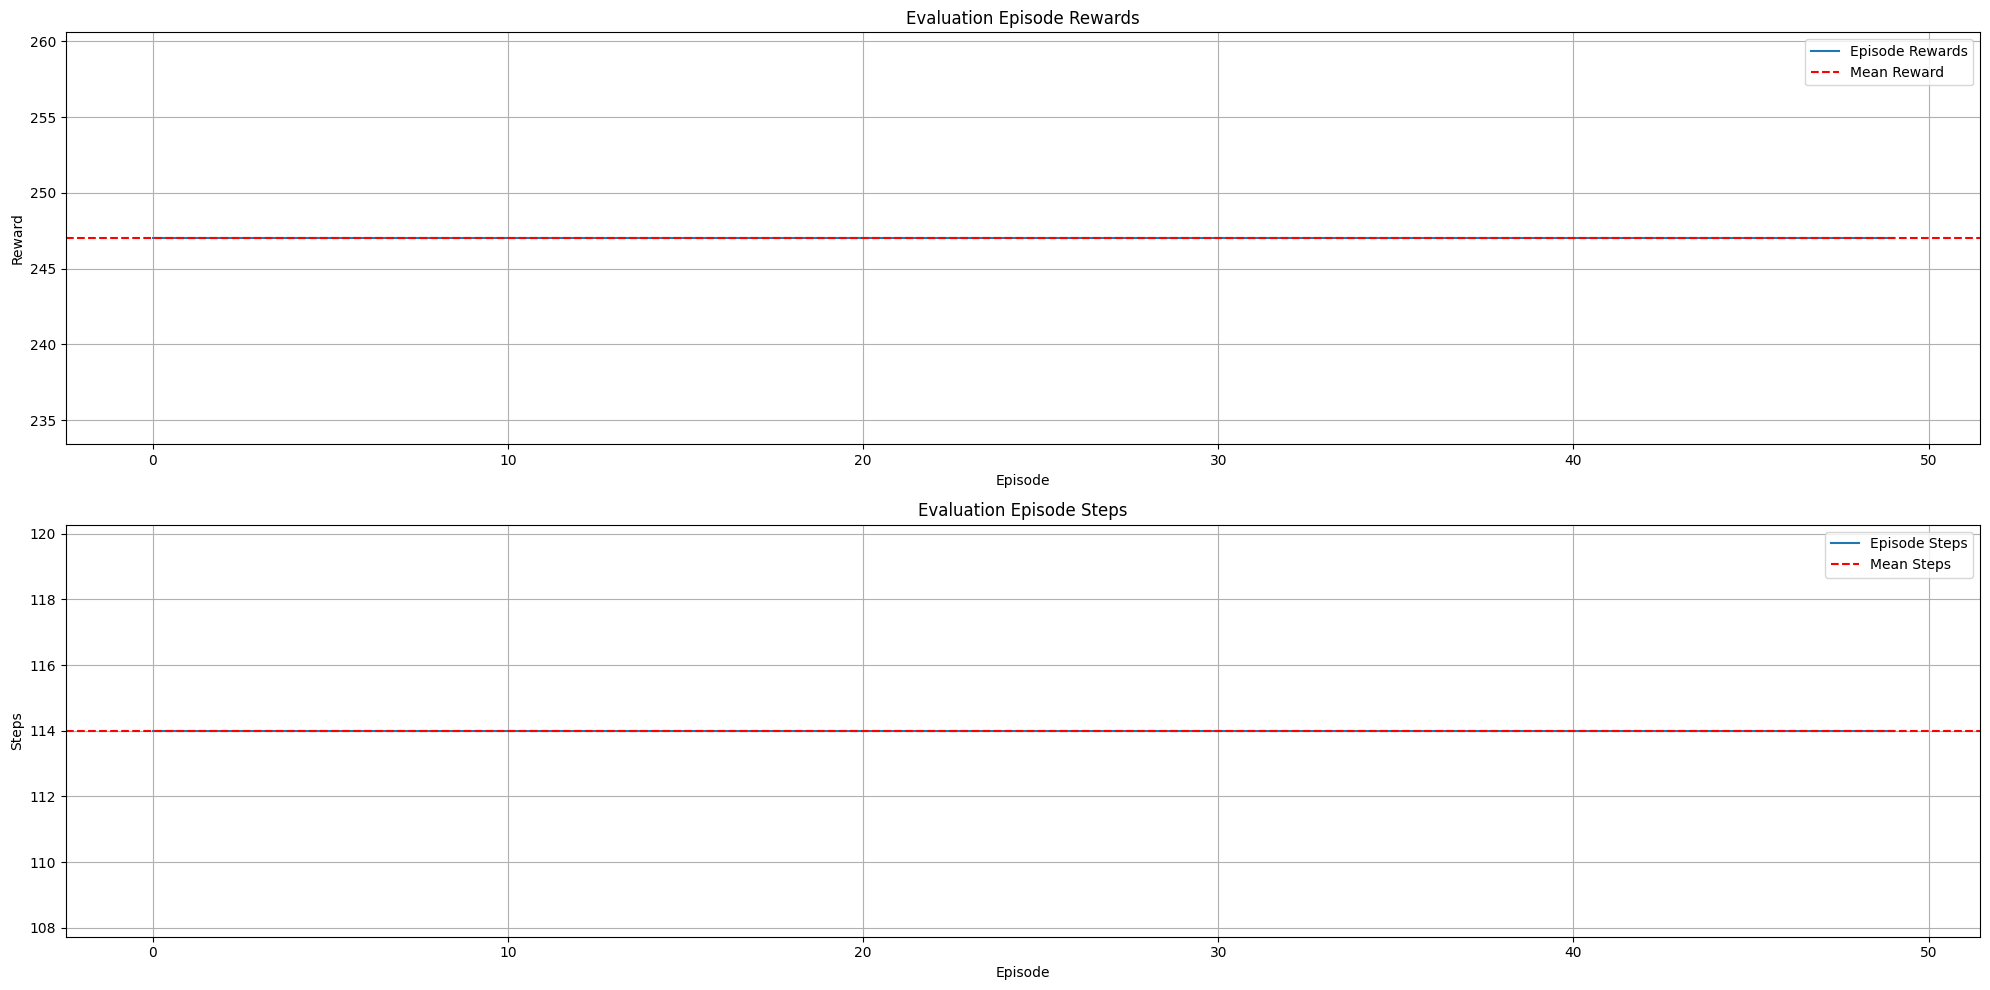

In [7]:
for episode in tqdm(range(1, num_episodes + 1)):
    state = env.reset()
    total_reward = 0
    steps = 0
    resetnow = False
    # Initiate loop for the current episode to play the game until it ends
    while resetnow == False:
        # To visualize the game
        env.render()
        action = agent.selectAction(state)
        next_state, reward, resetnow, info = env.step(action)
        resetnow = resetnow
        agent.saveExp(state, action, next_state, reward, resetnow)
        q, loss = agent.learn_get_TDest_loss()
        state = next_state
        total_reward = total_reward + reward
        steps = steps + 1
    print(
        f"Episode {episode} abgeschlossen mit {steps} Schritten, Gesamtbelohnung: {total_reward}, Epsilon: {agent.epsilon}\n\n"
    )
    # Save the results of the current episode
    reward_list.append(total_reward)
    steps_list.append(steps)

# Plot the results of all episodes at the defined intervals
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
axes = axes.flatten()

axes[0].plot(np.arange(len((reward_list))), reward_list, label="Episode Rewards")
axes[0].axhline(np.mean(reward_list), color="r", linestyle="--", label="Mean Reward")
axes[0].set_title("Evaluation Episode Rewards")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Reward")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(np.arange(len((steps_list))), steps_list, label="Episode Steps")
axes[1].axhline(np.mean(steps_list), color="r", linestyle="--", label="Mean Steps")
axes[1].set_title("Evaluation Episode Steps")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Steps")
axes[1].legend()
axes[1].grid(True)

fig.tight_layout()
fig.savefig(os.path.join(evaluation_folder, "evaluation_results.png"))

# Close the environment
env.close()